# 1. Time Series Decomposition

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
!wget https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv -P datasets/

--2024-11-29 19:11:43--  https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279 (5.2K) [text/plain]
Saving to: ‘datasets/example_retail_sales.csv.1’

example_retail_sale 100%[===================>]   5.16K  --.-KB/s    in 0s      

2024-11-29 19:11:44 (59.2 MB/s) - ‘datasets/example_retail_sales.csv.1’ saved [5279/5279]



## 1-1. Log Transform

## 1-2. Box-Cox Transform

## 1-3. Classical Decomposition
### 1-3-1. Classical Decomposition with pandas

In [3]:
df = pd.read_csv("datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


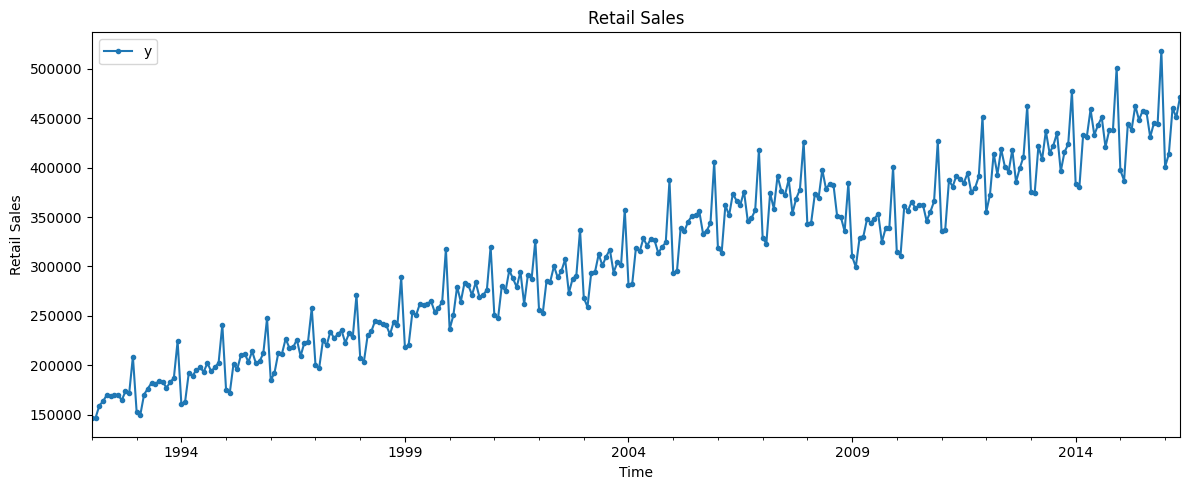

In [4]:
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
plt.tight_layout()

In [5]:
# Compute trend
window_size = 12
df["trend"] = (
    df.rolling(window=window_size)
    .mean()  # Apply the 12-MA without a centered window
    # The average is computed at the end of the window
    .rolling(window=2)
    .mean()  # Apply the 2-MA without a centred window
    # The average is computed at the end of the window
    .shift(-window_size // 2)  # Shift is required to align the 2x4-MA to what a
    # centered window would have produced
    # Integer division is used as shift() requires an int
)

In [6]:
# De-trend
df["y_detrended"] = df["y"] - df["trend"]
df.head()

,y,trend,y_detrended
ds,,,
1992-01-01,146376,NaN,NaN
1992-02-01,147079,NaN,NaN
1992-03-01,159336,NaN,NaN
1992-04-01,163669,NaN,NaN
1992-05-01,170068,NaN,NaN


In [7]:
# Average over each month
df["month"] = df.index.month
df.head()

,y,trend,y_detrended,month
ds,,,,
1992-01-01,146376,NaN,NaN,1
1992-02-01,147079,NaN,NaN,2
1992-03-01,159336,NaN,NaN,3
1992-04-01,163669,NaN,NaN,4
1992-05-01,170068,NaN,NaN,5


In [8]:
seasonality = df.groupby("month").mean()["y_detrended"]
seasonality.name = "seasonality"
seasonality

month
1    -31085.898551
2    -32941.297101
3      3032.637681
4     -2933.978261
5     13554.688406
6      4457.835145
7      4140.364583
8     10267.178819
9    -11945.057292
10    -3233.472222
11    -1135.296875
12    47751.626812
Name: seasonality, dtype: float64

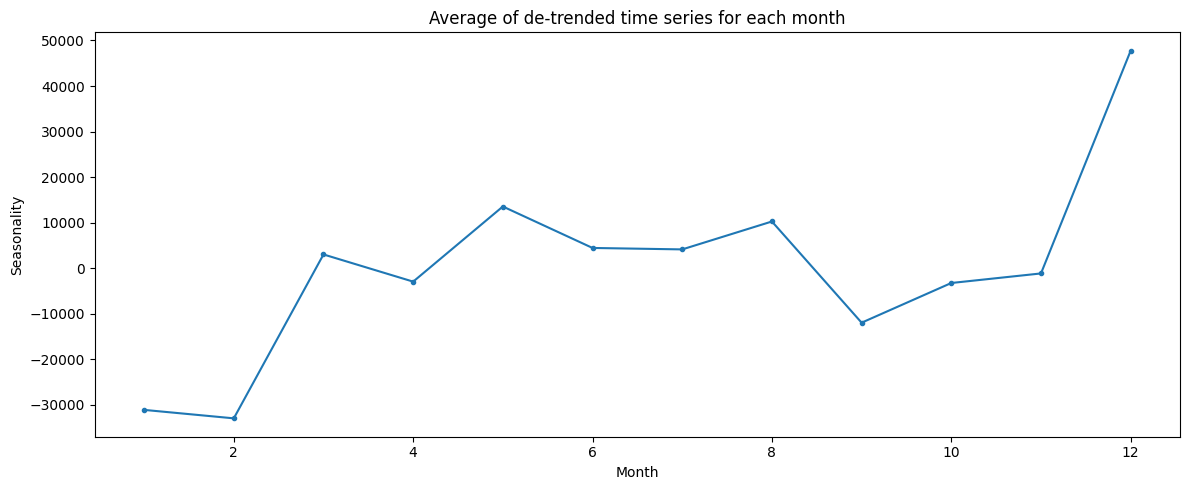

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])
seasonality.plot(y="seasonality", ax=ax, marker=".")
ax.set_xlabel("Month")
ax.set_ylabel("Seasonality")
ax.set_title("Average of de-trended time series for each month")
plt.tight_layout()

In [10]:
df = df.merge(right=seasonality, left_on="month", right_index=True)
df = df.sort_index()
df.head()

,y,trend,y_detrended,month,seasonality
ds,,,,,
1992-01-01,146376,NaN,NaN,1,-31085.898551
1992-02-01,147079,NaN,NaN,2,-32941.297101
1992-03-01,159336,NaN,NaN,3,3032.637681
1992-04-01,163669,NaN,NaN,4,-2933.978261
1992-05-01,170068,NaN,NaN,5,13554.688406


In [11]:
df["residual"] = df["y"] - df["trend"] - df["seasonality"]
df.head()

,y,trend,y_detrended,month,seasonality,residual
ds,,,,,,
1992-01-01,146376,NaN,NaN,1,-31085.898551,NaN
1992-02-01,147079,NaN,NaN,2,-32941.297101,NaN
1992-03-01,159336,NaN,NaN,3,3032.637681,NaN
1992-04-01,163669,NaN,NaN,4,-2933.978261,NaN
1992-05-01,170068,NaN,NaN,5,13554.688406,NaN


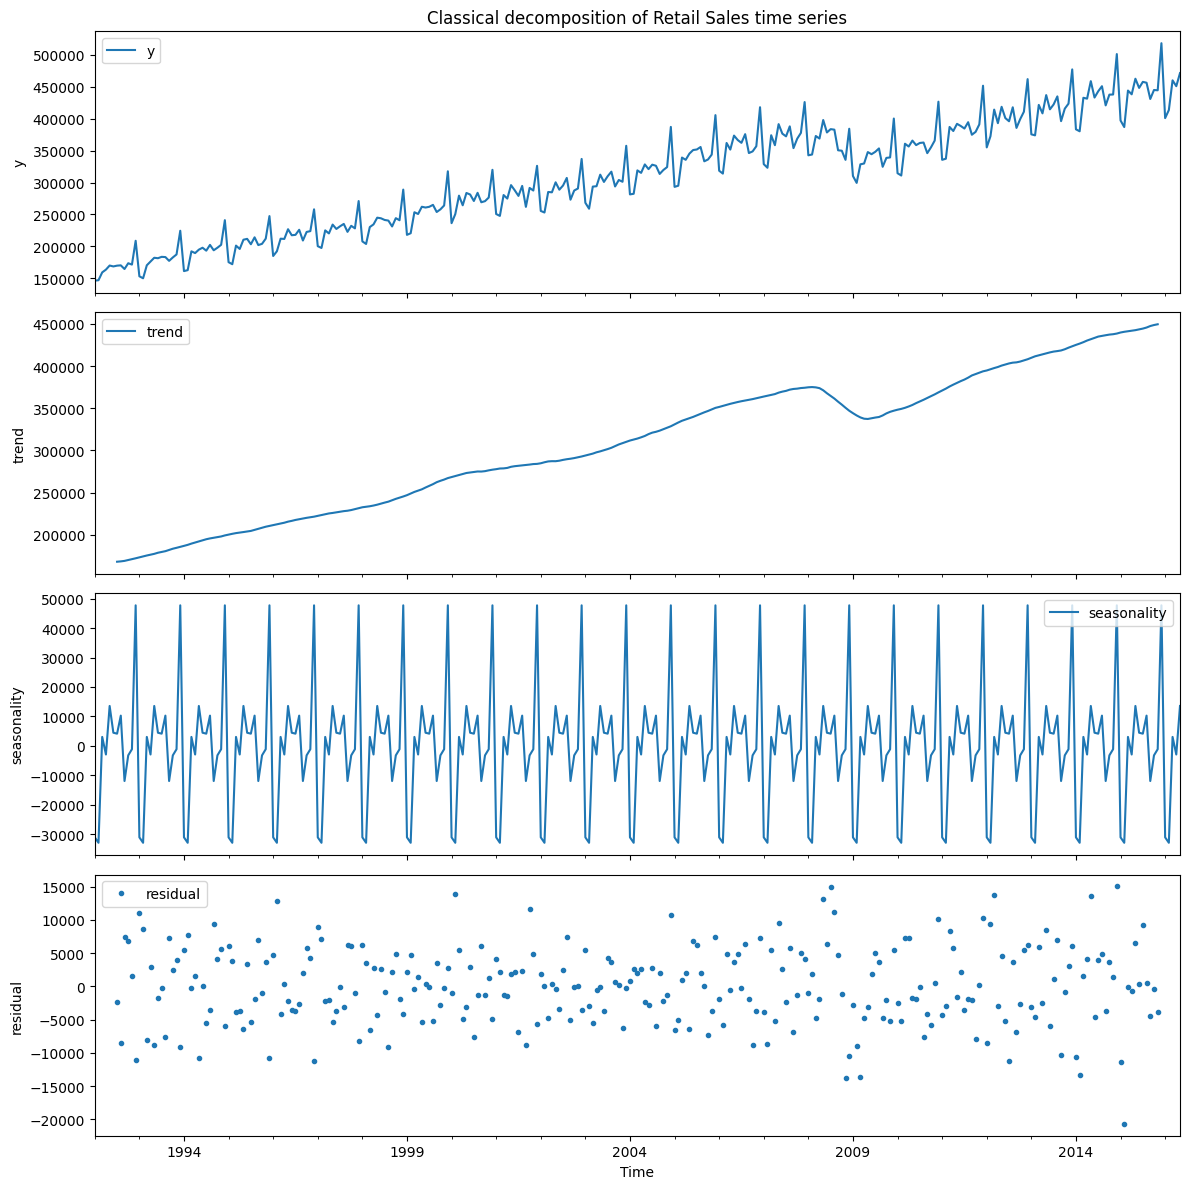

In [12]:
fig, ax = plt.subplots(nrows=4, figsize=[12, 12], sharex=True)

df["y"].plot(ax=ax[0], legend="y")
ax[0].set_ylabel("y")

df["trend"].plot(ax=ax[1], legend="trend")
ax[1].set_ylabel("trend")

df["seasonality"].plot(ax=ax[2], legend="seasonality")
ax[2].set_ylabel("seasonality")

df["residual"].plot(ax=ax[3], marker=".", legend="residual", ls="None")
ax[3].set_ylabel("residual")

ax[0].set_title("Classical decomposition of Retail Sales time series")
ax[3].set_xlabel("Time")

plt.tight_layout()

### 1-3-2. Classical Decomposition with statsmodels

In [13]:
res = seasonal_decompose(x=df["y"], model="additive", period=12)
res.trend.head(10)

ds
1992-01-01              NaN
1992-02-01              NaN
1992-03-01              NaN
1992-04-01              NaN
1992-05-01              NaN
1992-06-01              NaN
1992-07-01    168127.041667
1992-08-01    168537.583333
1992-09-01    169125.541667
1992-10-01    170120.958333
Name: trend, dtype: float64

In [14]:
res.seasonal.head(10)

ds
1992-01-01   -31080.009479
1992-02-01   -32935.408030
1992-03-01     3038.526752
1992-04-01    -2928.089190
1992-05-01    13560.577477
1992-06-01     4463.724216
1992-07-01     4146.253655
1992-08-01    10273.067891
1992-09-01   -11939.168220
1992-10-01    -3227.583151
Name: seasonal, dtype: float64

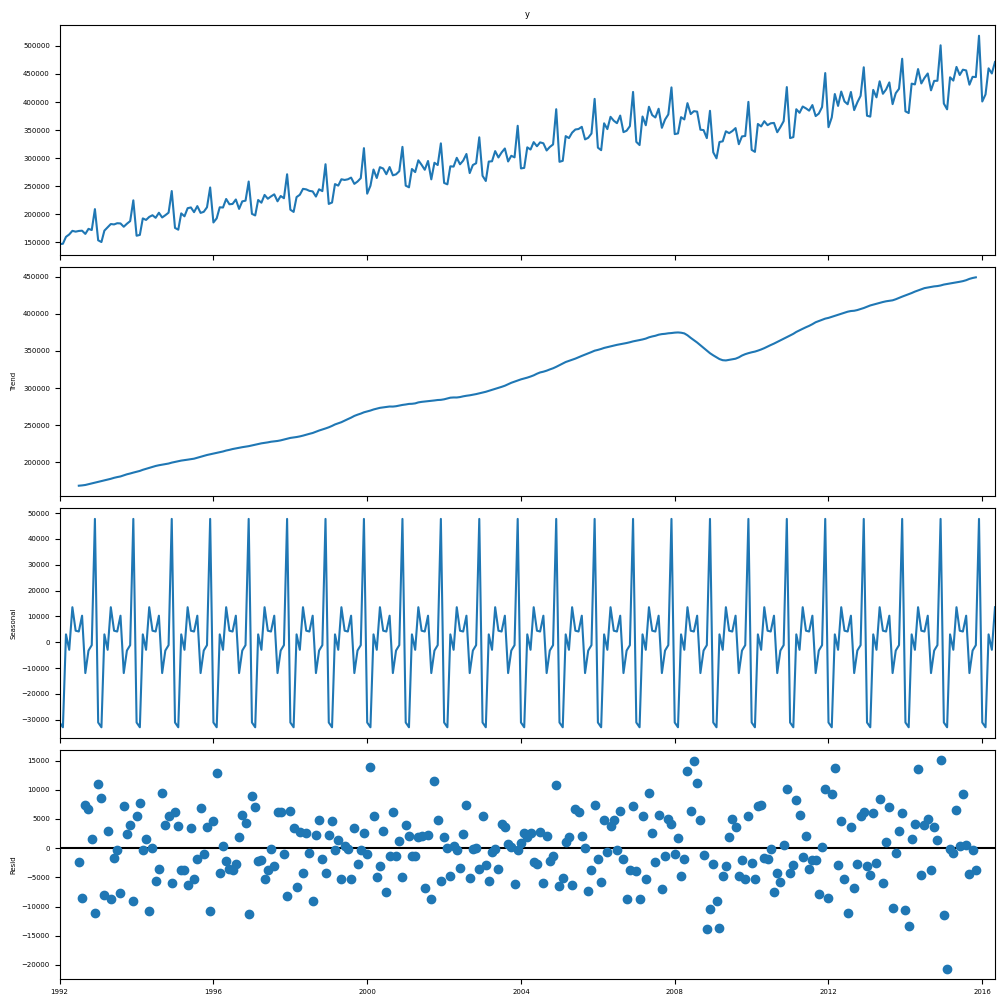

In [15]:
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

## 1-4. LOWESS

In [20]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

In [17]:
df = pd.read_csv("datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"])
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


In [18]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01'],
              dtype='datetime64[ns]', name='ds', length=293, freq=None)

In [21]:
# The input of lowess need to be numpy arrays and a numeric type
y = df["y"]
x = np.arange(0, len(y))  # datetime is not a numeric type
# so we use a sequence of integers
# for the x-values for the purpose of fitting

# lowess returns an array where the first column
# are the x values and the second column are the
# values of the fit at those x values

res = lowess(
    endog=y,  # the y values
    exog=x,  # the corresponding x values
    frac=0.1,  # fraction of dataset to use in window
    it=3,  # Number of iterations for robust regression.
    # The default value of 3 is typically good enough [1].
)

res[:10,]

array([[0.00000000e+00, 1.56224386e+05],
       [1.00000000e+00, 1.57578127e+05],
       [2.00000000e+00, 1.58916267e+05],
       [3.00000000e+00, 1.60244262e+05],
       [4.00000000e+00, 1.61568493e+05],
       [5.00000000e+00, 1.62894959e+05],
       [6.00000000e+00, 1.64228160e+05],
       [7.00000000e+00, 1.65570864e+05],
       [8.00000000e+00, 1.66923576e+05],
       [9.00000000e+00, 1.68283960e+05]])

In [22]:
# Append the lowess curve to the original dataframe
df["lowess"] = res[:, 1]
df.head()

,y,lowess
ds,,
1992-01-01,146376,156224.385686
1992-02-01,147079,157578.127266
1992-03-01,159336,158916.267408
1992-04-01,163669,160244.261688
1992-05-01,170068,161568.493429


Text(0.5, 0, 'Time')

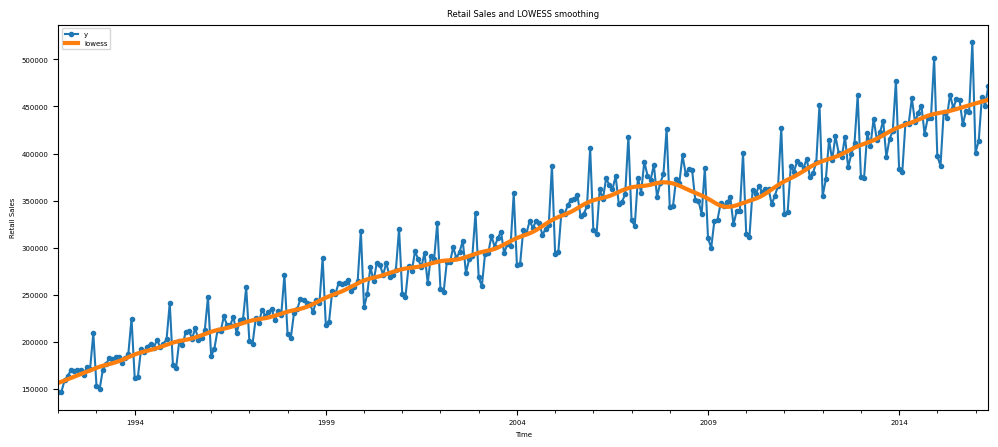

In [23]:
# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)
ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

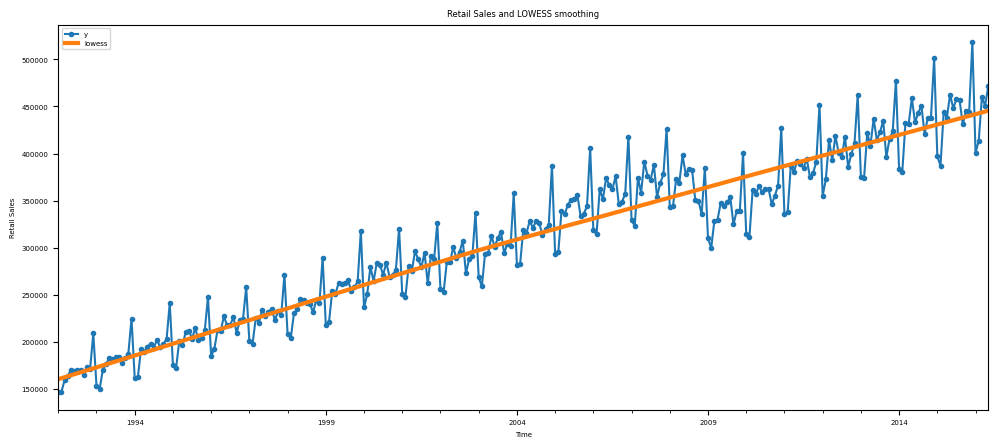

In [24]:
# Too large
frac = 0.9
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

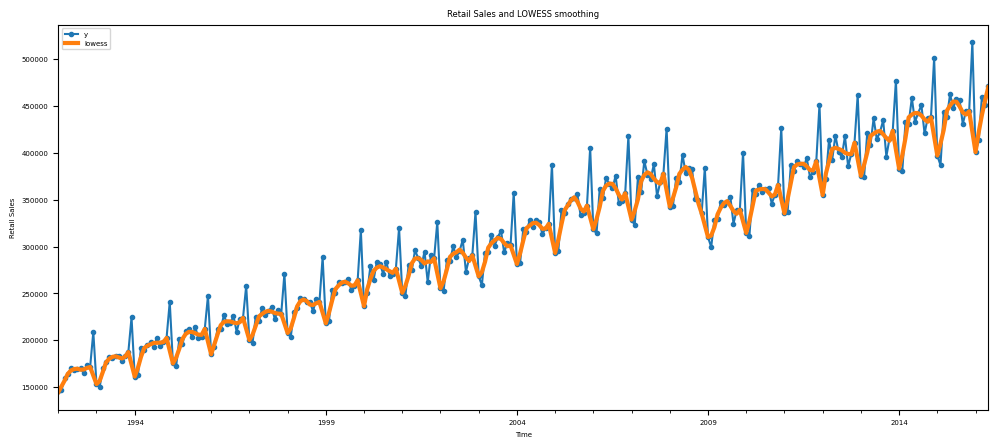

In [25]:
# Too small
frac = 0.02
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

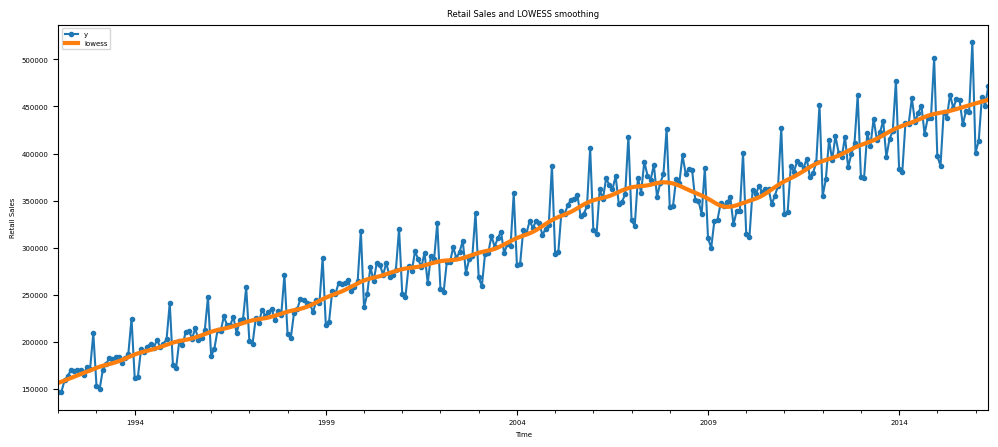

In [26]:
# A good visual fit
frac = 0.1
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

### 1-4-1. Hyperparameter Tunning with K-Fold Cross Validation

In [27]:
from sklearn.model_selection import KFold

In [28]:
# Helper function to compute the RMSE
def rmse(y, yhat):
    e = y - yhat
    return np.sqrt(np.mean(e**2))

cv_score_by_f = dict()  # Initialise an empty dict to store results
X = np.arange(0, len(df), dtype=float)
y = df["y"].values

for f in np.arange(0.04, 1.02, 0.02):  # Scan over values from 0.04 to 1
    cv_results = []  # Initialise list to store the result for each fold
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in kfold.split(X, y):
        # Split the data
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # Compute lowess fit
        y_pred = lowess(
            endog=y_train,  # the y values
            exog=X_train,  # the corresponding x values
            frac=f,  # fraction of dataset to use in window
            xvals=X_test,  # Return fitted values only for specific x values
        )

        # Compute loss function
        loss = rmse(y_test, y_pred)
        cv_results.append(loss)

    # Compute average and standard error across all folds
    cv_score_mean = np.mean(cv_results)
    cv_score_by_f[f] = cv_score_mean

results = pd.Series(cv_score_by_f)  # Convert results to pandas dataframe
results.head()

0.04    23698.959305
0.06    22704.912111
0.08    22392.879583
0.10    22023.141726
0.12    21868.979833
dtype: float64

Text(0, 0.5, 'RMSE')

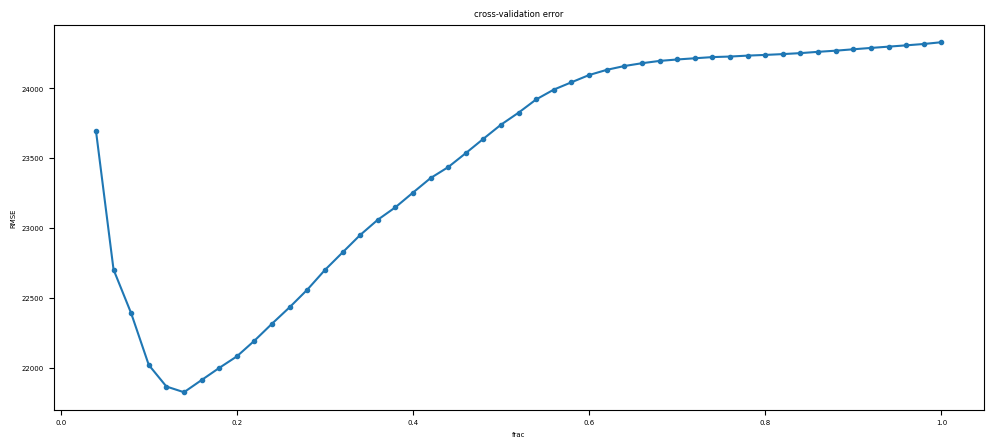

In [29]:
ax = results.plot(marker=".", figsize=[12, 5])
ax.set_xlabel("frac")
ax.set_title("cross-validation error")
ax.set_ylabel("RMSE")

In [30]:
results.index[results.argmin()]

0.13999999999999999

Text(0.5, 0, 'Time')

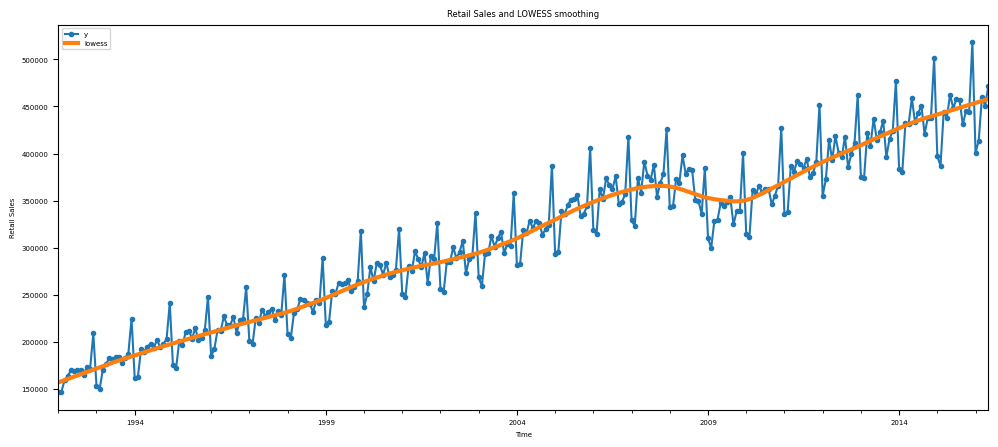

In [31]:
frac = 0.14
y = df["y"]
x = np.arange(0, len(y))
res = lowess(endog=y, exog=x, frac=frac)
df["lowess"] = res[:, 1]

# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
df.plot(y="y", marker=".", ax=ax)
df.plot(y="lowess", ax=ax, linewidth=3)

ax.set_title("Retail Sales and LOWESS smoothing")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

## 1-5. STL